In [36]:
%matplotlib inline
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [37]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [38]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

In [156]:
RE_EMAIL = re.compile(
    r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])")
RE_URL = re.compile(r"((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*")
RE_RELAX_PHONE = re.compile('(\(? ?[\d]{2,3} ?\)?.{,3}?){2,}')
# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line matches the regular expression "^[\s]*---*[\s]*$".
RE_SEPARATOR = re.compile('^[\s]*---*[\s]*')
RE_REPLY = re.compile('^\>')
RE_REPLY_PUNCT = re.compile('^[^A-Za-z0-9]{1,2}\>')
RE_TAB = re.compile('\t')
RE_WROTE = re.compile('\s(wr[oi]tes?:)$')

# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line has a sequence of 10 or more special characters.
RE_SPECIAL_CHARS = re.compile(('^[\s]*([\*]|#|[\+]|[\^]|-|[\~]|[\&]|[\$]|_|[\!]|'
                               '[\/]|[\%]|[\:]|[\=]){10,}[\s]*$'))

RE_SIGNATURE_WORDS = re.compile(('(T|t)hank.*,|(B|b)est|(R|r)egards|(W|w)ishes|'
                                 '^sent[ ]{1}from[ ]{1}my[\s,!\w]*$|BR|(S|s)incerely|'
                                 '(C|c)orporation|\b[Cc]orp\b|Group|[Ff]ax|[Ee]?mail|[Pp]hone|[Ww]ww|WWW'))

# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line contains a pattern like Vitor R. Carvalho or William W. Cohen.
RE_NAME = re.compile('[A-Z][a-z]+\s\s?[A-Z][\.]?\s\s?[A-Z][a-z]+')

RE_HEADER_WORDS = re.compile('([Ff]rom|[Tt]o|[Ss]ubject|[Cc]c|[Bb]cc):|[Ff]orwarded')


def punct_percent(line):
    if len(line) == 0:
        return 0
    punct = [c for c in line if c in string.punctuation]
    return len(punct) / len(line)


def alphanum_percent(line):
    if len(line) == 0:
        return 0
    punct = [c for c in line if c.isalnum()]
    return len(punct) / len(line)

def num_percent(line):
    if len(line) == 0:
        return 0
    punct = [c for c in line if c.isdigit()]
    return len(punct) / len(line)

In [40]:
feature_dict = {
        'blank': lambda doc: 1 if len(doc[0].strip()) == 0 else 0,
        'email': lambda doc: 1 if RE_EMAIL.search(doc[0]) else 0,
        'url': lambda doc: 1 if RE_URL.search(doc[0]) else 0,
        'phone': lambda doc: 1 if RE_RELAX_PHONE.search(doc[0]) else 0,
        'sigdelimiter': lambda doc: 1 if RE_SEPARATOR.match(doc[0]) else 0,
        'special': lambda doc: 1 if RE_SPECIAL_CHARS.search(doc[0]) else 0,
        'words': lambda doc: 1 if RE_SIGNATURE_WORDS.search(doc[0]) else 0,
        'header': lambda doc: 1 if RE_HEADER_WORDS.search(doc[0]) else 0,
        'name': lambda doc: 1 if RE_NAME.search(doc[0]) else 0,
        'endquote': lambda doc: 1 if doc[0].endswith("\"") else 0,
        'tabs1': lambda doc: 1 if len(RE_TAB.findall(doc[0])) == 1 else 0,
        'tabs2': lambda doc: 1 if len(RE_TAB.findall(doc[0])) == 2 else 0,
        'tabs3': lambda doc: 1 if len(RE_TAB.findall(doc[0])) >= 3 else 0,
        'punct20': lambda doc: 1 if punct_percent(doc[0]) >= 0.2 else 0,
        'punct50': lambda doc: 1 if punct_percent(doc[0]) >= 0.5 else 0,
        'punct90': lambda doc: 1 if punct_percent(doc[0]) >= 0.9 else 0,
        'reply': lambda doc: 1 if RE_REPLY.match(doc[0]) else 0,
        'startpunct': lambda doc: 1 if doc[0].startswith(tuple(p for p in string.punctuation)) else 0,
        'firstchar': lambda doc: doc[0][0] if len(doc[0]) > 0 else "",
        'replypunct': lambda doc: 1 if RE_REPLY_PUNCT.match(doc[0]) else 0,
        'wrote': lambda doc: 1 if RE_WROTE.search(doc[0]) else 0,
        'alphanum90': lambda doc: 1 if alphanum_percent(doc[0]) < 0.9 else 0,
        'alphanum50': lambda doc: 1 if alphanum_percent(doc[0]) < 0.5 else 0,
        'alphanum10': lambda doc: 1 if alphanum_percent(doc[0]) < 0.1 else 0,
        'num90': lambda doc: 1 if num_percent(doc[0]) < 0.9 else 0,
        'num50': lambda doc: 1 if num_percent(doc[0]) < 0.5 else 0,
        'num10': lambda doc: 1 if num_percent(doc[0]) < 0.1 else 0,
        'title': lambda doc: 1 if doc[0].strip().istitle() else 0
    }

In [41]:
ENTITY_PATTERN = "^#sig#"
def line_to_entity(line, filename, i):
    m = re.match(ENTITY_PATTERN, line)
    if m:
        e = {
            "line": line[5:],
            "filename": filename,
            "entity": "signature",
            "len": len(line[5:]),
            "lineNo": i+1
        }
    else:
        e = {"line": line, "filename": filename, "entity": "no_entity", "len": len(line), "lineNo": i+1}    
    doc = tuple((e["line"],))
    for feature, fn in feature_dict.items():            
        e[feature] = fn(doc)    
    return e

In [42]:
def remove_blanks(lines):    
    return [line for line in lines if len(line.strip()) > 0]

In [43]:
def strip_blank_lines(lines, leading=True, trailing=True):
    leading_blank = 0
    trailing_blank = len(lines)
    lines_it = iter(lines)
    next_line = next(lines_it, None)
    while next_line is not None and len(next_line.strip()) == 0:
        leading_blank += 1
        next_line = next(lines_it, None)

    if trailing:
        it_reversed = iter(reversed(lines))
        next_line = next(it_reversed, None)
        while next_line is not None and len(next_line.strip()) == 0:
            trailing_blank -= 1
            next_line = next(it_reversed, None)
    return lines[leading_blank:trailing_blank]

In [44]:
def get_signature_length(ents):
    """ Signature length in number of lines """
    return sum(1 for e in ents if e["entity"] == "signature")

In [45]:
files_path = r"F:\Documents\stopansko\masters\thesis\sig-detect\data\clean\enron_random"
filenames = [f for f in os.listdir(files_path) if os.path.isfile(os.path.join(files_path, f))]

In [46]:
files = list()
entities = list()
for filename in filenames:
    with open(os.path.join(files_path, filename), mode="r", encoding="utf-8") as f:
        lines = f.read().splitlines()
        lines = strip_blank_lines(lines)
        non_blanks = remove_blanks(lines)
        if len(non_blanks) > 0:
            lengths = [len(line) for line in lines]
            file_entities = [line_to_entity(line, filename, i) for i, line in enumerate(lines)]
            entities.extend(file_entities)
            files.append({
                "filename": filename,
                "nlines": len(lines),
                "len_avg": np.ceil(np.mean(lengths)),
                "len_min": min(lengths),
                "len_max": max(lengths),
                "nBlanks": len(lines) - len(non_blanks),
                "nNonBlanks": len(non_blanks),
                "nSig": get_signature_length(file_entities) # lengh of the signature in lines
            })
        
df_files = pd.DataFrame(files) 
entities = pd.DataFrame(entities)

In [47]:
master = entities.merge(df_files, on="filename")

In [53]:
master.iloc[150:164,]

,line,filename,entity,len,lineNo,blank,email,url,phone,sigdelimiter,...,last11,posRatio,posRatioFromEnd,posRatioNB,lenRatio,lenRatioMax,less_avg_len,more_avg_len,less_avg_len75,less_avg_len50
150,Yes there are many different subs that have be...,allen-p_all_documents_113,no_entity,69,151,0,0,0,0,0,...,1,0.94375,0.05625,1.086331,1.301887,0.907895,0,1,0,0
151,provide these if you are interested.,allen-p_all_documents_113,no_entity,36,152,0,0,0,0,0,...,1,0.95000,0.05000,1.093525,0.679245,0.473684,1,0,1,0
152,,allen-p_all_documents_113,no_entity,0,153,1,0,0,0,0,...,1,0.95625,0.04375,1.100719,0.000000,0.000000,1,0,1,1
153,"I know I have not answered everything, but thi...",allen-p_all_documents_113,no_entity,74,154,0,0,0,0,0,...,1,0.96250,0.03750,1.107914,1.396226,0.973684,0,1,0,0
154,when you have reviewed and we can discuss furt...,allen-p_all_documents_113,no_entity,50,155,0,0,0,0,0,...,1,0.96875,0.03125,1.115108,0.943396,0.657895,1,0,0,0
155,,allen-p_all_documents_113,no_entity,0,156,1,0,0,0,0,...,1,0.97500,0.02500,1.122302,0.000000,0.000000,1,0,1,1
156,"Sincerely,",allen-p_all_documents_113,signature,10,157,0,0,0,0,0,...,1,0.98125,0.01875,1.129496,0.188679,0.131579,1,0,1,1
157,,allen-p_all_documents_113,signature,0,158,1,0,0,0,0,...,1,0.98750,0.01250,1.136691,0.000000,0.000000,1,0,1,1
158,George Richards,allen-p_all_documents_113,signature,15,159,0,0,0,0,0,...,1,0.99375,0.00625,1.143885,0.283019,0.197368,1,0,1,1
159,"President, Creekside Builders, LLC",allen-p_all_documents_113,signature,34,160,0,0,0,0,0,...,1,1.00000,0.00000,1.151079,0.641509,0.447368,1,0,1,0


In [54]:
master.dtypes

line                object
filename            object
entity              object
len                  int64
lineNo               int64
blank                int64
email                int64
url                  int64
phone                int64
sigdelimiter         int64
special              int64
words                int64
header               int64
name                 int64
endquote             int64
tabs1                int64
tabs2                int64
tabs3                int64
punct20              int64
punct50              int64
punct90              int64
reply                int64
startpunct           int64
firstchar           object
replypunct           int64
wrote                int64
alphanum90           int64
alphanum50           int64
alphanum10           int64
title                int64
nlines               int64
len_avg            float64
len_min              int64
len_max              int64
nBlanks              int64
nNonBlanks           int64
nSig                 int64
p

In [55]:
master["posFromEnd"] = master.nlines - master.lineNo
master["last"] = master.posFromEnd.apply(lambda x: 1 if x == 0 else 0)
master["prevlast"] = master.posFromEnd.apply(lambda x: 1 if x == 1 else 0)
master["last5"] = master.posFromEnd.apply(lambda x: 1 if x < 5 else 0)
master["last11"] = master.posFromEnd.apply(lambda x: 1 if x < 11 else 0)
master["posRatio"] = master.lineNo / master.nlines # 1 = last
master["posRatioFromEnd"] = master.posFromEnd / master.nlines # 1 = last
master["posRatioNB"] = master.lineNo / master.nNonBlanks # 1 = last
master["lenRatio"] = master.len / master.len_avg
master["lenRatioMax"] = master.len / master.len_max

master["less_avg_len"] = master.apply(lambda row: 1 if row.len <= row.len_avg else 0, axis=1)
master["more_avg_len"] = master.apply(lambda row: 1 if row.len > row.len_avg else 0, axis=1)
master["less_avg_len75"] = master.apply(lambda row: 1 if row.len <= (row.len_avg*.75) else 0, axis=1)
master["less_avg_len50"] = master.apply(lambda row: 1 if row.len <= (row.len_avg*.5) else 0, axis=1)

# Note: Consider adding quantile for the position of the line.

Meaning in which quantile of the message is the line

In [56]:
master.loc[150:165:,("line", "posFromEnd", "last", "prevlast", "last5", "last11", "posRatio", "posRatioNB", "len", "len_avg", "lenRatio")]

,line,posFromEnd,last,prevlast,last5,last11,posRatio,posRatioNB,len,len_avg,lenRatio
150,Yes there are many different subs that have be...,9,0,0,0,1,0.943750,1.086331,69,53.0,1.301887
151,provide these if you are interested.,8,0,0,0,1,0.950000,1.093525,36,53.0,0.679245
152,,7,0,0,0,1,0.956250,1.100719,0,53.0,0.000000
153,"I know I have not answered everything, but thi...",6,0,0,0,1,0.962500,1.107914,74,53.0,1.396226
154,when you have reviewed and we can discuss furt...,5,0,0,0,1,0.968750,1.115108,50,53.0,0.943396
155,,4,0,0,1,1,0.975000,1.122302,0,53.0,0.000000
156,"Sincerely,",3,0,0,1,1,0.981250,1.129496,10,53.0,0.188679
157,,2,0,0,1,1,0.987500,1.136691,0,53.0,0.000000
158,George Richards,1,0,1,1,1,0.993750,1.143885,15,53.0,0.283019
159,"President, Creekside Builders, LLC",0,1,0,1,1,1.000000,1.151079,34,53.0,0.641509


In [57]:
master.sample(10).loc[:,("len", "len_avg", "less_avg_len", "more_avg_len", "line", "hasCid")]

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\pandas\core\indexing.py:805: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


,len,len_avg,less_avg_len,more_avg_len,line,hasCid
13561,69,51.0,0,1,stress option will remain available for the fi...,NaN
9131,72,43.0,0,1,"below 7.5 percent, triggering an emergency ale...",NaN
11481,38,42.0,1,0,Gene Humphrey\tDan McCarty\tMike Terraso,NaN
10721,55,35.0,0,1,"Bargainer/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT,...",NaN
8042,1,41.0,1,0,,NaN
11596,27,18.0,0,1,Shannon.McPearson@enron.com,NaN
1870,77,46.0,0,1,to disregard all testing done by the first com...,NaN
12677,6,19.0,1,0,S. Pan,NaN
12789,74,43.0,0,1,"? Curve management: clear responsibilities, pe...",NaN
12061,13,28.0,1,0,- 018_18.JPG,NaN


In [58]:
all_features = feature_dict.keys() | ["last", "prevlast", "last5", "last11"]

In [59]:
signatures = master[master.entity == "signature"]

In [60]:
NOTsignatures = master[master.entity != "signature"]

In [61]:
len(signatures) + len(NOTsignatures)

18028

In [62]:
len(master)

18028

# What words are typical for signatures?

In [115]:
stop_words = "the and you to or of this for is in if are at by on it".split(" ")

In [110]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [155]:
get_top_n_words(signatures.line, 30)

[('thanks', 109),
 ('com', 91),
 ('713', 90),
 ('enron', 51),
 ('fax', 48),
 ('regards', 33),
 ('http', 33),
 ('www', 33),
 ('your', 33),
 ('853', 30),
 ('thank', 27),
 ('email', 27),
 ('any', 26),
 ('phone', 26),
 ('texas', 23),
 ('mail', 22),
 ('corp', 21),
 ('646', 19),
 ('intended', 18),
 ('please', 18),
 ('best', 16),
 ('houston', 16),
 ('smith', 15),
 ('be', 15),
 ('mike', 15),
 ('77002', 15),
 ('sincerely', 14),
 ('inc', 14),
 ('use', 14),
 ('north', 14)]

In [112]:
get_top_n_words(NOTsignatures.line, 10)

[('enron', 1186),
 ('ect', 1128),
 ('that', 751),
 ('be', 700),
 ('will', 667),
 ('com', 630),
 ('with', 589),
 ('have', 574),
 ('hou', 571),
 ('we', 567)]

# 👉 More stop words in non-signatures

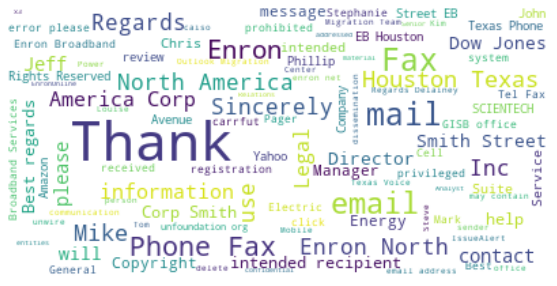

In [101]:
from wordcloud import WordCloud
# Generate a word cloud image
text = " ".join(signatures.line)
wordcloud = WordCloud().generate(text)

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


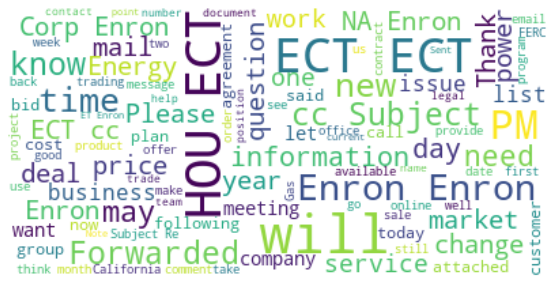

In [106]:
from wordcloud import WordCloud
# Generate a word cloud image
text = " ".join(NOTsignatures.line)
wordcloud = WordCloud().generate(text)

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [126]:
def get_unique_words(corpus):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    return set(vec.get_feature_names()) # probably set it not needed but just to be sure

# Find unique words for signatures

In [135]:
unique_sig_words = get_unique_words(signatures.line)
unique_non_sig_words = get_unique_words(NOTsignatures.line)

In [136]:
print(f"Unique words in signatures: {len(unique_sig_words)}")
print(f"Unique words in NOT signatures: {len(unique_non_sig_words)}")

Unique words in signatures: 1474
Unique words in NOT signatures: 11242


In [141]:
unique_only_in_sig = [w for w in unique_sig_words if w not in unique_non_sig_words and not w.isdigit()]

In [142]:
print(f"Unique words ONLY in signatures: {len(unique_only_in_sig)}")

Unique words ONLY in signatures: 214


In [145]:
get_top_n_words(unique_only_in_sig, 10)

[('square', 1),
 ('g_nther', 1),
 ('hg', 1),
 ('dg', 1),
 ('ab', 1),
 ('cgc', 1),
 ('rockefeller', 1),
 ('mdelarosa', 1),
 ('jp', 1),
 ('enersen', 1)]

***👉 There are no good unique only to the signatures words, most are names and addresses***

# How often there are digits in signatures vs the rest?

In [150]:
print(f"Digits in signatures: {len([w for w in unique_sig_words if w.isdigit()])}")
print(f"Digits in signatures: {len([w for w in unique_non_sig_words if w.isdigit()])}")

Digits in signatures: 303
Digits in signatures: 649


In [154]:
# maybe parts of phone numbers are longer digits?
print(f"Digits in signatures: {len([w for w in unique_sig_words if w.isdigit() and len(w) > 3])}")
print(f"Digits in signatures: {len([w for w in unique_non_sig_words if w.isdigit() and len(w) > 3])}")

Digits in signatures: 174
Digits in signatures: 281


***👉 There are more digits unique to non-signatures but they are also much more data, not helpful***

# Where are the signatures in the text?

In [24]:
# Median file length
print(f"Median file length: {np.median(df_files.nlines)}")
print(f"Average file length: {np.mean(df_files.nlines)}")

Median file length: 21.5
Average file length: 34.94767441860465


In [25]:
df_files.nlines.quantile(np.arange(0, 1, .25))

0.00     1.0
0.25     9.0
0.50    21.5
0.75    42.0
Name: nlines, dtype: float64

In [26]:
df_files.nlines.quantile(np.arange(.5, 1, .05))  # 75% have under 100 lines

0.50     21.50
0.55     25.00
0.60     28.00
0.65     32.00
0.70     36.50
0.75     42.00
0.80     50.00
0.85     59.00
0.90     79.50
0.95    110.75
Name: nlines, dtype: float64

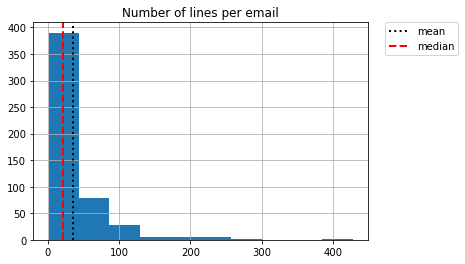

In [27]:
plt.hist(df_files.nlines)
plt.axvline(df_files.nlines.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(df_files.nlines.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Number of lines per email")
plt.grid()
plt.show()

In [28]:
min(df_files.nlines) # shortest email

1

In [29]:
len(df_files.loc[df_files.nlines==1,])

22

In [30]:
df_files.loc[df_files.nlines==1,]

,filename,nlines,len_avg,len_min,len_max,nBlanks,nNonBlanks,nSig
22,badeer-r_all_documents_280,1,16.0,16,16,0,1,0
29,bass-e_all_documents_1106,1,27.0,27,27,0,1,0
59,buy-r_all_documents_103,1,36.0,36,36,0,1,0
61,buy-r_all_documents_142,1,21.0,21,21,0,1,0
103,derrick-j_all_documents_15,1,60.0,60,60,0,1,0
124,farmer-d_all_documents_4852,1,32.0,32,32,0,1,0
141,gay-r_all_documents_383,1,63.0,63,63,0,1,0
153,gilbertsmith-d_all_documents_95,1,67.0,67,67,0,1,0
201,hendrickson-s_all_documents_38,1,54.0,54,54,0,1,0
219,hyvl-d_all_documents_1531,1,54.0,54,54,0,1,0


In [31]:
max(df_files.nlines) # longest email

428

In [32]:
len(df_files.loc[df_files.nlines>100,])

34

In [33]:
master.loc[master.nlines>200,["line", "filename", "entity", "len", "nlines"]]

,line,filename,entity,len,nlines
4192,"Great--Steve, what's your phone no. ? The ope...",fossum-d_all_documents_1110,no_entity,75,226
4193,like to talk for a few minutes on this. Thank...,fossum-d_all_documents_1110,no_entity,51,226
4194,,fossum-d_all_documents_1110,no_entity,0,226
4195,,fossum-d_all_documents_1110,no_entity,0,226
4196,,fossum-d_all_documents_1110,no_entity,0,226
...,...,...,...,...,...
17648,>,wheldon-c_all_documents_163,signature,1,263
17649,> Sandra Vizzacchero Goldman,wheldon-c_all_documents_163,signature,46,263
17650,> Executive Assistant to Avi Nash Sachs,wheldon-c_all_documents_163,signature,44,263
17651,> Chemicals Equity Research Team,wheldon-c_all_documents_163,signature,32,263


In [34]:
# Signature length in number of lines
print(f"Median signature length: {master.nSig.median()} lines")
print(f"Mean signature length: {master.nSig.mean()} lines")

Median signature length: 3.0 lines
Mean signature length: 5.159651749570233 lines


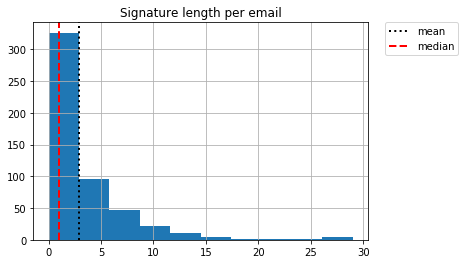

In [35]:
plt.hist(df_files.nSig)
plt.axvline(df_files.nSig.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(df_files.nSig.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Signature length per email")
plt.grid()
plt.show()

In [36]:
nsig_to_nlines = df_files.nSig / df_files.nlines

In [37]:
nsig_to_nlines.mean()*100

12.479375354076318

In [38]:
master.nSig.median() / master.nlines.median() # the median signature is 15% of the median file (all lines)

0.05084745762711865

In [39]:
master.nSig.median() / master.nNonBlanks.median() # the median signature is 44% of the median file (non-blank lines)

0.06976744186046512

In [40]:
noreplies = master[~master.line.str.startswith(">")]

In [41]:
# Median file length without replies
print(f"Median file length: {np.median(noreplies.nNonBlanks)}")
print(f"Average file length: {np.mean(noreplies.nNonBlanks)}")

Median file length: 41.0
Average file length: 67.66682131879604


In [42]:
# Line No of signatures
print(f"Median lineNo: {np.median(signatures.lineNo)}")
print(f"Average lineNo: {np.mean(signatures.lineNo)}")

Median lineNo: 25.0
Average lineNo: 44.42007926023778


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3AC09EA08>]],
      dtype=object)

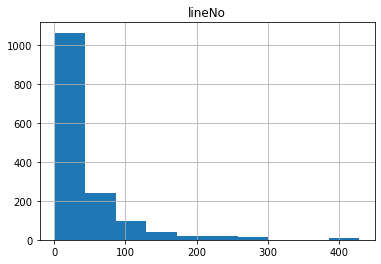

In [43]:
signatures.hist(column="lineNo")

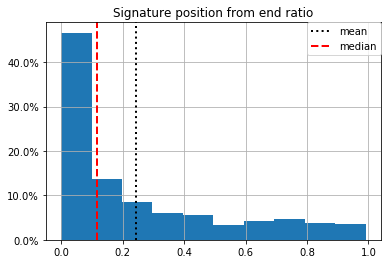

In [44]:
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
#plt.ylim(top=1)
plt.hist(signatures.posRatioFromEnd, weights=np.ones(len(signatures)) / len(signatures))
#plt.hist(signatures.posRatioFromEnd)
plt.axvline(signatures.posRatioFromEnd.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(signatures.posRatioFromEnd.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(loc='best', borderaxespad=0.)
plt.title("Signature position from end ratio")
plt.grid()
plt.show()

In [45]:
print(f"Mean signatures.posRatioFromEnd: {signatures.posRatioFromEnd.mean()}")
print(f"Median signatures.posRatioFromEnd: {signatures.posRatioFromEnd.median()}")

Mean signatures.posRatioFromEnd: 0.243435303088259
Median signatures.posRatioFromEnd: 0.11620294599018004


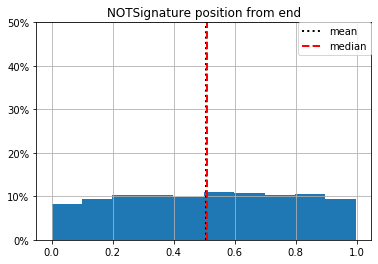

In [46]:
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylim(top=.5)
plt.hist(NOTsignatures.posRatioFromEnd, weights=np.ones(len(NOTsignatures)) / len(NOTsignatures))
# plt.hist(NOTsignatures.posRatioFromEnd)
plt.axvline(NOTsignatures.posRatioFromEnd.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(NOTsignatures.posRatioFromEnd.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(loc='best', borderaxespad=0.)
plt.title("NOTSignature position from end")
plt.grid()
plt.show()

In [47]:
signatures.posFromEnd.quantile(np.arange(.5, 1, .05))

0.50     4.0
0.55     5.0
0.60     6.0
0.65     8.0
0.70    11.0
0.75    16.0
0.80    22.0
0.85    30.0
0.90    45.0
0.95    74.0
Name: posFromEnd, dtype: float64

In [48]:
NOTsignatures.posFromEnd.quantile(np.arange(0, 1, .05))

0.00      0.0
0.05      2.0
0.10      5.0
0.15      7.0
0.20      9.0
0.25     12.0
0.30     14.0
0.35     17.0
0.40     20.0
0.45     23.0
0.50     27.0
0.55     32.0
0.60     37.0
0.65     43.0
0.70     51.0
0.75     61.0
0.80     74.0
0.85     91.0
0.90    118.0
0.95    166.0
Name: posFromEnd, dtype: float64

# How much can be explained only from posFromEnd?

In [49]:
# label encoding
master["entity"] = master["entity"].astype('category')
master["entity_code"] = master["entity"].cat.codes

In [50]:
master.loc[:, ["entity", "entity_code", "entity_code_reversed"]]

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,entity,entity_code,entity_code_reversed
0,no_entity,0,NaN
1,no_entity,0,NaN
2,no_entity,0,NaN
3,no_entity,0,NaN
4,no_entity,0,NaN
...,...,...,...
18028,no_entity,0,NaN
18029,no_entity,0,NaN
18030,signature,1,NaN
18031,signature,1,NaN


In [51]:
from sklearn.linear_model import LogisticRegression
X, y = master.posFromEnd.values.reshape(-1, 1), master.entity_code
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, y)

In [52]:
clf.classes_

array([0, 1], dtype=int8)

In [53]:
[a[0]*100 for a in clf.coef_] 
# [-13.458100885847173] - 
# negative coefficient, negative relationsip, 
# the bigger the number, the less likely is to be a signature

[-2.933178284945649]

In [54]:
from scipy import stats
stats.pointbiserialr(master.posFromEnd, master.entity_code)

PointbiserialrResult(correlation=-0.1511102811001602, pvalue=1.4189663337225155e-92)

In [55]:
from sklearn.linear_model import LogisticRegression
X, y = master.posRatio.values.reshape(-1, 1), master.entity_code
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, y)

In [56]:
clf.coef_

array([[3.70069722]])

In [57]:
from scipy import stats
stats.pointbiserialr(master.posRatio, master.entity_code)

PointbiserialrResult(correlation=0.25348691676241436, pvalue=2.1757821273284649e-262)

# Point biserial vs Logistic Regression
All three procedures can yield, if this is of interest, p-values telling the probability that results as far or farther from the usual null hypothesis would occur if chance alone were responsible. Beyond that, each procedure will give a different type of potentially useful information:

* Point-biserial correlation will yield a coefficient ranging from -1 to 1, summarizing (in somewhat abstract or scale-free terms) the degree of connection between age and smoking status. (Note that the lesser-used "biserial correlation" works somewhat differently: see explanation).
* T-testing will describe the mean age difference between smokers and non-smokers in terms of the standard error of such a difference.
* Logistic regression will yield the difference in (the odds of being a smoker) that is associated with each unit (presumably year) difference in age. Logistic regression can also be used to generate a probability that each person is a smoker, based on age.

Thus in a given research situation these procedures may well turn out to be complementary.
https://stats.stackexchange.com/questions/189234/which-is-better-how-they-differ-independent-t-test-or-simple-logistic-regressio

https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/

# Relationships between continuous and categorical variables
One useful way to explore the relationship between a continuous and a categorical variable is with a set of side by side box plots, one for each of the categories. Similarities and differences between the category levels can be seen in the length and position of the boxes and whiskers.

https://www.ssc.wisc.edu/sscc/pubs/DWE/book/3-3-sect-ggplot-categorical.html

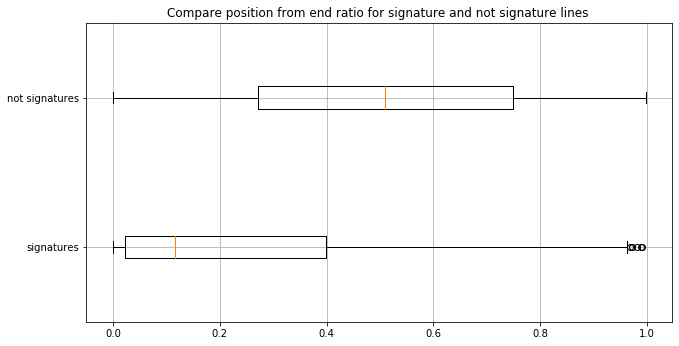

In [58]:
plt.boxplot([signatures.posRatioFromEnd, NOTsignatures.posRatioFromEnd], vert=False, labels=["signatures", "not signatures"])
plt.title("Compare position from end ratio for signature and not signature lines ")
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
plt.grid()
plt.show()

(array([1345., 1565., 1690., 1691., 1635., 1826., 1760., 1704., 1745.,
        1558.]),
 array([0.        , 0.09976636, 0.19953271, 0.29929907, 0.39906542,
        0.49883178, 0.59859813, 0.69836449, 0.79813084, 0.8978972 ,
        0.99766355]),
 <a list of 10 Patch objects>)

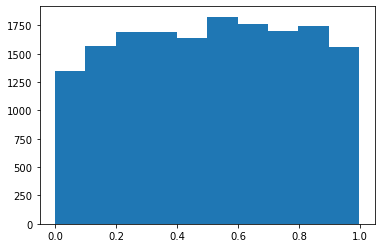

In [59]:
plt.hist(NOTsignatures.posRatioFromEnd)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3B1641388>]],
      dtype=object)

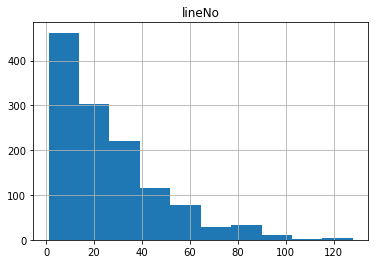

In [60]:
signatures[signatures.nlines-signatures.nBlanks < 75].hist(column="lineNo")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3B16C0848>,
      dtype=object)

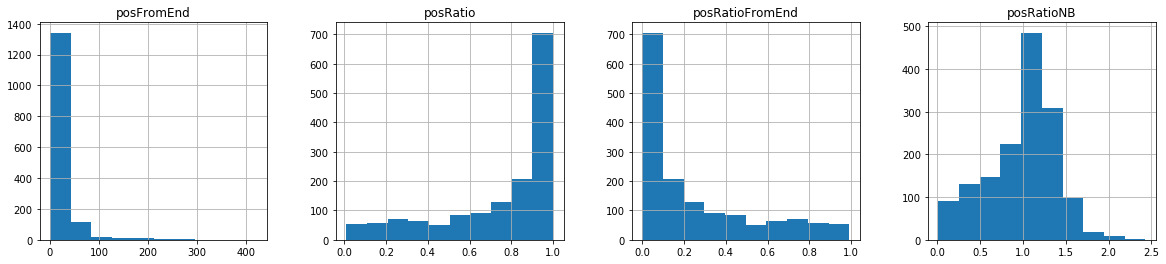

In [61]:
signatures.loc[:, ("posRatioNB", "posRatio", "posRatioFromEnd", "posFromEnd" )].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3B192ED08>,
      dtype=object)

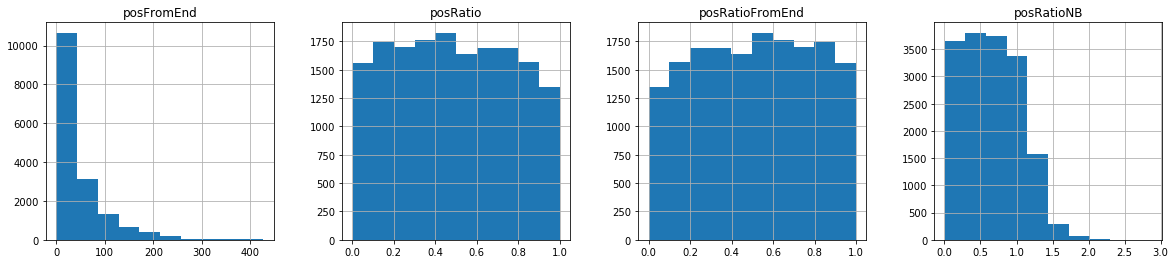

In [62]:
NOTsignatures.loc[:, ("posRatioNB", "posRatio", "posRatioFromEnd", "posFromEnd" )].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3B1C60248>,
      dtype=object)

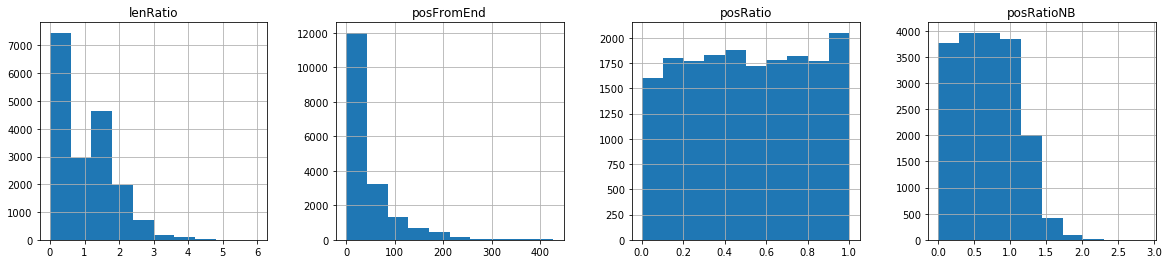

In [63]:
master.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3B21C0D08>,
      dtype=object)

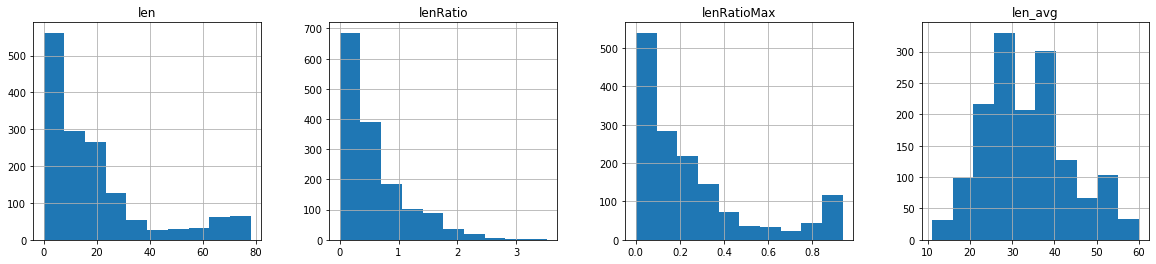

In [64]:
signatures.loc[:, ("len", "len_avg", "lenRatio", "lenRatioMax" )].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3B216B708>,
      dtype=object)

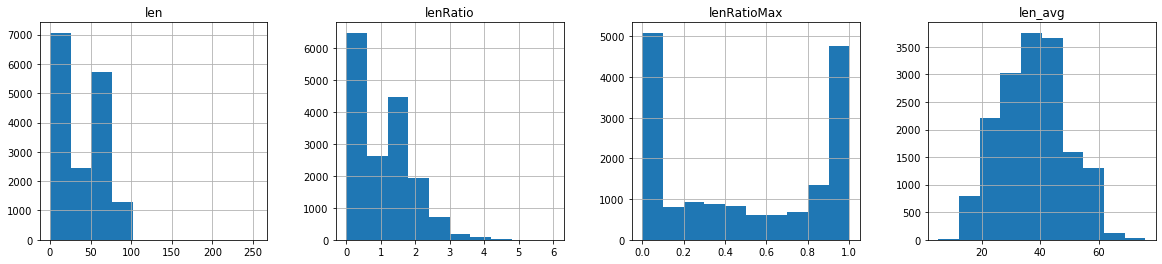

In [65]:
NOTsignatures.loc[:, ("len", "len_avg", "lenRatio", "lenRatioMax" )].hist(layout=(1,4), figsize=(20,4))

In [66]:
signatures.len.describe()

count    1514.000000
mean       18.953765
std        20.195554
min         0.000000
25%         5.000000
50%        13.000000
75%        24.000000
max        78.000000
Name: len, dtype: float64

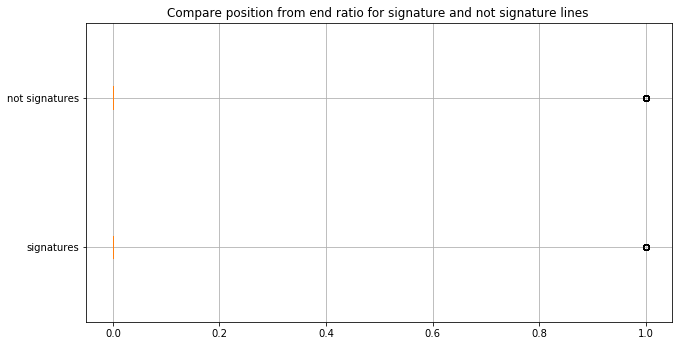

In [67]:
plt.boxplot([signatures.email, NOTsignatures.email], vert=False, labels=["signatures", "not signatures"])
plt.title("Compare position from end ratio for signature and not signature lines ")
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
plt.grid()
plt.show()

In [68]:
def plot_stacked(columns):
    labels = [x for c in columns for x in [f"{c}_Sig", f"{c}_NOTSig"]]

    fig, ax = plt.subplots()
    plt.xticks(rotation=80)
    yes = list()
    no = list()

    for col in columns:
        all_sig = signatures.loc[:, col]
        yes_sig = signatures.loc[signatures[col] == 1, col]
        no_sig = signatures.loc[signatures[col] == 0, col]

        all_NOTsig = NOTsignatures.loc[:, col]
        yes_NOTsig = NOTsignatures.loc[NOTsignatures[col] == 1, col]
        no_NOTsig = NOTsignatures.loc[NOTsignatures[col] == 0, col]

        yes.extend([len(yes_sig)/len(all_sig), len(yes_NOTsig)/len(all_NOTsig)])
        no.extend([len(no_sig)/len(all_sig), len(no_NOTsig)/len(all_NOTsig)])


    ax.bar(labels, yes, 0.35, color="green")
    ax.bar(labels, no, 0.35, bottom=yes, color="orange")

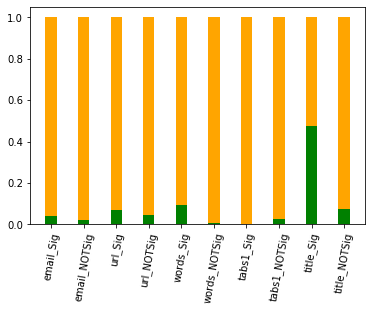

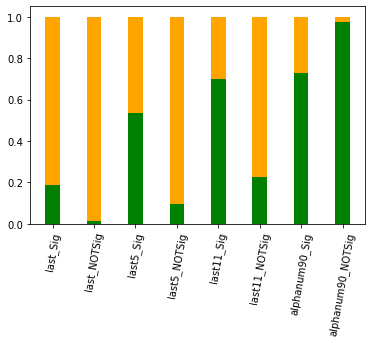

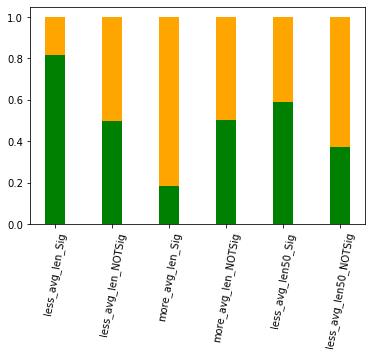

In [69]:
plot_stacked(["email", "url", "words", "tabs1", "title"])
plot_stacked(["last", "last5", "last11", "alphanum90"])
plot_stacked(["less_avg_len", "more_avg_len", "less_avg_len50"])

In [70]:
signatures.loc[:, "email"]

156      0
157      0
158      0
159      0
169      0
        ..
18020    0
18021    0
18030    0
18031    0
18032    0
Name: email, Length: 1514, dtype: int64

In [71]:
labels = ["email"]
yes_emails = 
fig, ax = plt.subplots()


SyntaxError: invalid syntax (<ipython-input-71-5962f9a0143d>, line 2)

In [72]:
len(NOTsignatures.email[NOTsignatures.email==1])

377

# Features

In [73]:
print(f"There are {sum(signatures.email)} email matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.phone)} phone matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.name)} name matches out of {len(signatures.index)} signature lines.") # Too low?

There are 58 email matches out of 1514 signature lines.
There are 276 phone matches out of 1514 signature lines.
There are 19 name matches out of 1514 signature lines.


In [74]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column], margins=True))
        cross_tbl_labels.append(column)

In [75]:
display_side_by_side(cross_tables, cross_tbl_labels)

blank,0,1,All
entity,,,
no_entity,12302,4217,16519
signature,1309,205,1514
All,13611,4422,18033
email,0,1,All
entity,,,
no_entity,16142,377,16519
signature,1456,58,1514
All,17598,435,18033
url,0,1,All


In [76]:
def pvalue_to_star(pval):
    if pval > 0.05: return "ns"
    if pval <= 0.001: return "***"  
    if pval <= 0.01: return "**"
    if pval <= 0.05: return "*"

In [77]:
from scipy.stats import fisher_exact, chi2_contingency

In [78]:
chi_tests = list()
print("=== Chi Square Test ===")
for i, table in enumerate(cross_tables):    
    chi2, p, dof, expected = chi2_contingency(table)
    chi_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
chi_tests_df = pd.DataFrame(chi_tests)
chi_tests_df.round(5)

=== Chi Square Test ===


,feature,p_value,significance
0,blank,0.00000,***
1,email,0.00689,**
2,url,0.00017,***
3,phone,0.00000,***
4,sigdelimiter,0.01736,*
5,special,0.00006,***
6,words,0.00000,***
7,name,0.98847,ns
8,endquote,0.63395,ns
9,tabs1,0.00000,***


In [79]:
fisher_tests = list()
print("=== Fisher's Exact Test (only for no_entity vs signature) ===")
for i, table in enumerate(cross_tables):
    odds_ratio, p = fisher_exact(table.loc[("no_entity", "signature"),[0,1]])
    fisher_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
fisher_tests_df = pd.DataFrame(fisher_tests)
fisher_tests_df.round(5)

=== Fisher's Exact Test (only for no_entity vs signature) ===


,feature,p_value,significance
0,blank,0.00000,***
1,email,0.00043,***
2,url,0.00001,***
3,phone,0.00000,***
4,sigdelimiter,0.00016,***
5,special,0.00002,***
6,words,0.00000,***
7,name,0.65025,ns
8,endquote,0.12384,ns
9,tabs1,0.00000,***


In [80]:
chi_tests_df[chi_tests_df.p_value < 0.05]

,feature,p_value,significance
0,blank,2.268122e-22,***
1,email,6.890280e-03,**
2,url,1.655894e-04,***
3,phone,1.171223e-22,***
4,sigdelimiter,1.735919e-02,*
5,special,5.801975e-05,***
6,words,1.135528e-152,***
9,tabs1,4.218126e-06,***
10,tabs2,3.708102e-06,***
14,punct90,4.104138e-04,***


In [81]:
fisher_tests_df[fisher_tests_df.p_value < 0.05]

,feature,p_value,significance
0,blank,5.132192e-28,***
1,email,4.264624e-04,***
2,url,8.222033e-06,***
3,phone,4.552965e-22,***
4,sigdelimiter,1.568100e-04,***
5,special,2.173149e-05,***
6,words,2.899431e-82,***
9,tabs1,1.938212e-11,***
10,tabs2,4.851686e-12,***
13,punct50,7.973310e-03,**


In [82]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column]).apply(lambda r: round((r/r.sum())*100, 2), axis=1))
        cross_tbl_labels.append(column)
display_side_by_side(cross_tables, cross_tbl_labels)

blank,0,1
entity,,
no_entity,74.47,25.53
signature,86.46,13.54
email,0,1
entity,,
no_entity,97.72,2.28
signature,96.17,3.83
url,0,1
entity,,
no_entity,95.65,4.35


In [83]:
master.loc[master.line.str.contains("@") & (master.email == 0), ("line", "email")]

,line,email
291,To: John Arnold/HOU/ECT@ECT,0
376,To: Steve LaFontaine/GlobalCo@GlobalCo,0
800,If you encounter any errors please contact the...,0
824,To: Eric Bass/HOU/ECT@ECT,0
845,To: Celeste Roberts/HOU/ECT@ECT,0
...,...,...
17974,Miguel Maltes@ENRON_DEVELOPMENT,0
17976,To: Javier Chavarria/ENRON_DEVELOPMENT@ENRON_D...,0
17977,"cc: Greg Curran/CA/Enron@Enron, Federico",0
17978,"Haeussler/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT,...",0


In [84]:
master.columns

Index(['line', 'filename', 'entity', 'len', 'lineNo', 'blank', 'email', 'url',
       'phone', 'sigdelimiter', 'special', 'words', 'name', 'endquote',
       'tabs1', 'tabs2', 'tabs3', 'punct20', 'punct50', 'punct90', 'reply',
       'startpunct', 'firstchar', 'replypunct', 'wrote', 'alphanum90',
       'alphanum50', 'alphanum10', 'title', 'nlines', 'len_avg', 'len_min',
       'len_max', 'nBlanks', 'nNonBlanks', 'nSig', 'posFromEnd', 'last',
       'prevlast', 'last5', 'last11', 'posRatio', 'posRatioFromEnd',
       'posRatioNB', 'lenRatio', 'lenRatioMax', 'less_avg_len', 'more_avg_len',
       'less_avg_len75', 'less_avg_len50', 'entity_code'],
      dtype='object')

In [85]:
master.to_csv("master1.csv")
master.to_pickle("master1.pkl")